# Use manual data only

In [26]:
# Autoreload modules
%load_ext autoreload
%autoreload 2

from pandas import DataFrame
import pandas as pd
import numpy as np
from sklearn.feature_selection import (
    VarianceThreshold,
    GenericUnivariateSelect,
    SelectorMixin,
    chi2,
    f_classif,
    mutual_info_classif,
    SelectKBest,
    RFECV,
    SelectFromModel,
)

from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

from sklearn.preprocessing import Normalizer, StandardScaler

from mrp7pred.feats.selection import (
    _remove_low_variance_features,
    _remove_similar_features,
    _univariate,
    _from_model,
    _rfecv
)
from mrp7pred.preprocess import split_data
from mrp7pred.train import _train
from mrp7pred.utils import plot_roc_auc, plot_precision_recall, NoScaler
from mrp7pred.scoring import get_scoring

DATA_CC = "../mrp7pred/feats/all_features_cc/cc_full_features_828_20210115-135540.csv"
DATA_MAN = "../mrp7pred/feats/all_features_man/man_full_features_828_20210115-085233.csv"
FULL_DATA = "../data/all_compounds_828_features_renamed.csv"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load data

In [27]:
df_all = pd.read_csv(FULL_DATA, index_col=0)
df_cc = df_all[df_all["name"].str.contains("NSC")]
df_man = df_all[~df_all.name.isin(df_cc.name)]

In [7]:
grid_light = [
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [10, 100, 500, 1000],
        "clf__criterion": ["gini", "entropy"],
        "sclr__scaler": [StandardScaler()],
    },
    {
        "clf": [XGBClassifier()],
        "clf__learning_rate": [0.01, 0.1, 0.5, 1],
        "clf__n_estimators": [10, 100, 1000],
    },
    {
        "clf": [SVC(probability=True)],
        "clf__kernel": ["rbf"],
        "sclr__scaler": [StandardScaler()],
    },
#     {
#         "clf": [MLPClassifier()],
#         "clf__alpha": 10.0 ** -np.arange(1, 10, 2),
#         "clf__hidden_layer_sizes": np.arange(10, 15, 2),
#         "sclr__scaler": [StandardScaler()],
#     },
]

In [8]:
grid = [
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [10, 100, 500, 1000],
        "clf__criterion": ["gini", "entropy"],
        "clf__max_depth": [3, 5, 7],
        "sclr__scaler": [StandardScaler()],
    },
    {
        "clf": [XGBClassifier()],
        "clf__min_child_weight": [1, 5],
        "clf__gamma": [0, 1, 5],
        "clf__learning_rate": [0.001, 0.01, 0.1, 0.5],
        "clf__max_depth": [4, 5, 7],
        "clf__n_estimators": [10, 50, 100, 300, 500],
    },
    {
        "clf": [SVC(probability=True)],
        "clf__kernel": ["rbf"],
        "clf__C": [1, 50, 1000],
        "clf__gamma": [1e-3, 1e-4],
        "sclr__scaler": [StandardScaler()],
    },
#     {
#         "clf": [MLPClassifier()],
#         "clf__solver": ["lbfgs"],
#         "clf__alpha": 10.0 ** -np.arange(1, 10, 2),
#         "clf__hidden_layer_sizes": np.arange(10, 15, 2),
#         "sclr__scaler": [StandardScaler()],
#     },
]

In [9]:
grid_heavy = [
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [10, 100, 300, 500, 700, 1000],
        "clf__criterion": ["gini", "entropy"],
        "clf__max_depth": [3, 5, 7],
        "clf__min_samples_leaf": [10, 50, 100, 500, 1000],
        "clf__max_features": [0.1, 0.2, 0.4, 0.8, 1.0, "sqrt", "log2"],
        "sclr__scaler": [StandardScaler()],
    },
    {
        "clf": [XGBClassifier()],
        "clf__min_child_weight": [1, 5],
        "clf__gamma": [0, 1, 5],
        "clf__subsample": [0.6, 0.8, 1.0],
        "clf__colsample_bytree": [0.4, 0.7, 1.0],
        "clf__learning_rate": [0.001, 0.01, 0.1, 0.3, 0.5],
        "clf__max_depth": [4, 5, 7],
        "clf__n_estimators": [100, 300, 500, 700, 1000],
        "clf__scale_pos_weight": [10, 100, 1000],
        "sclr__scaler": [StandardScaler()],
    },
    {
        "clf": [SVC(probability=True)],
        "clf__kernel": ["rbf"],
        "clf__C": [1, 10, 100, 1000],
        "clf__gamma": [1e-3, 1e-4],
        "sclr__scaler": [StandardScaler()],
    },
    {
        "clf": [SVC(probability=True)],
        "clf__kernel": ["linear"],
        "clf__C": [1, 10, 100, 1000],
        "sclr__scaler": [StandardScaler()],
    },
    {
        "clf": [MLPClassifier()],
        "clf__solver": ["lbfgs"],
        "clf__max_iter": [1000, 1200, 1400, 1600, 1800, 2000],
        "clf__alpha": 10.0 ** -np.arange(1, 10),
        "clf__hidden_layer_sizes": np.arange(10, 15),
        "sclr__scaler": [StandardScaler()],
    },
]

In [10]:
df_man

,name,smiles,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,rdk_NumAliphaticHeterocycles,...,pychem_ATSe8,pychem_ATSp1,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8,label
0,paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0.446809,62.0,802.510,4.0,15.0,7.0,3.0,1.0,...,5.184,4.058,4.421,4.610,4.691,4.805,4.894,4.829,4.748,1
1,vincristine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.565217,60.0,768.524,3.0,14.0,9.0,1.0,5.0,...,5.159,4.047,4.528,4.759,4.967,4.988,4.985,4.913,4.799,1
2,LTC4,CCCCCC=CCC=CC=CC=CC(SCC(NC(=O)CCC(N)C(=O)O)C(=...,0.566667,43.0,578.409,8.0,12.0,0.0,0.0,0.0,...,4.316,3.625,3.715,3.760,3.789,3.831,3.863,3.902,3.888,1
3,E217bG,CC12CCC3c4ccc(O)cc4CCC3C1CCC2OC1OC(C(=O)O)C(O)...,0.708333,32.0,416.256,5.0,8.0,5.0,3.0,1.0,...,3.811,3.451,3.843,3.915,3.791,3.648,3.590,3.502,3.258,1
4,gemcitabine,Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1,0.555556,18.0,252.112,4.0,7.0,2.0,0.0,1.0,...,1.615,2.614,2.903,2.835,2.645,2.489,2.138,1.619,0.860,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,CCTA-45,O=C(Nc1cccc(-c2cc(F)cc(F)c2)c1)C(Cl)Cl,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,...,2.683,2.987,3.254,3.163,3.045,3.063,2.856,2.604,2.351,0
112,CCTA-46,O=C(Nc1cccc(-c2cc(F)c(F)c(F)c2)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,2.877,3.003,3.278,3.198,3.060,3.078,2.892,2.650,2.399,0
113,CCTA-47,O=C(Nc1cccc(-c2cc(F)ccc2F)c1)C(Cl)Cl,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,...,2.807,2.987,3.254,3.177,3.055,3.067,2.849,2.590,2.365,0
114,CCTA-48,O=C(Nc1cccc(-c2ccc(F)c(F)c2F)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,2.981,3.003,3.278,3.211,3.075,3.078,2.885,2.636,2.412,0


In [32]:
name_train, name_test, X_train, y_train, X_test, y_test = split_data(
    df_man.rename(columns={"std_smiles":"smiles"}), 
    ratio=0.7, 
    featurized=True,
    random_state=712,
)
len(X_train), len(y_train), len(X_test), len(y_test)

Spliting training and test data ... Done!
train_1: 38; train_0: 43; test_1: 15; test_0: 20


(81, 81, 35, 35)

# 1. Only remove similar features


`experiment 1`: threshold = 0.8, grid=light, num_feats = 350

tp: 11.0,
fp: 13.0,
tn: 7.0,
fn: 4.0, 
roc_auc: 0.585, 
accuracy: 0.5142857142857142, 
precision: 0.4583333333333333, 
recall: 0.7333333333333333, 
specificity: 0.35, 
mcc: 0.0888336318148377

`experiment 2`: threshold = 0.9, grid = light, num_feats = 420

tp: 12.0
fp: 7.0
tn: 13.0
fn: 3.0
score
roc_auc: 0.8066666666666668
accuracy: 0.7142857142857143
precision: 0.631578947368421
recall: 0.8
specificity: 0.65
mcc: 0.4470296705094523

`experiment 3`: not use MLP, threshold = 0.9, grid = grid_light, num_feats = 420

`experiment 4`: threshold = 0.95, grid = grid_balance, num_feats = 475

Pipeline(steps=[('sclr', StandardScaler()),
                ('clf',
                 RandomForestClassifier(class_weight={0: 0.99, 1: 0.01}))])

tp: 14.0
fp: 9.0
tn: 11.0
fn: 1.0

roc_auc: 0.8366666666666667
accuracy: 0.7142857142857143
precision: 0.6086956521739131
recall: 0.9333333333333333
specificity: 0.55
mcc: 0.503909833971264

`experiment 5`: threshold = 0.99, grid = grid_balance_7, score = precision, num_feats = 610, 

TODO: 

Seems that some feature in exp2 not in exp1 is important. Try RFECV using Pipeline(steps=[('sclr', DummyScaler(scaler=StandardScaler())),
                ('clf', MLPClassifier(alpha=1e-05, hidden_layer_sizes=12))])

In [33]:
support_similar, X_train = _remove_similar_features(X_train, threshold=0.9)
X_train.shape

Calculating correlation matrix ... Done!
Creating correlation graph ... Done!


(81, 420)

In [34]:
X_test = X_test.iloc[:, support_similar]
X_test.shape

(35, 420)

In [35]:
support_similar

array([  0,   6,   7,  11,  15,  16,  18,  19,  23,  24,  25,  29,  33,
        34,  35,  37,  39,  41,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  61,  62,  64,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  82,  83,
        84,  85,  87,  88,  90,  91,  92,  93,  94,  95,  97,  98, 100,
       101, 102, 103, 104, 105, 130, 133, 138, 156, 162, 163, 164, 165,
       168, 173, 174, 175, 178, 184, 190, 192, 193, 197, 199, 213, 214,
       228, 245, 246, 250, 257, 259, 263, 271, 274, 278, 279, 291, 295,
       300, 301, 302, 303, 319, 325, 326, 327, 343, 351, 359, 366, 367,
       374, 385, 386, 389, 390, 391, 392, 397, 398, 399, 400, 401, 402,
       405, 407, 410, 412, 413, 415, 416, 418, 419, 420, 422, 423, 425,
       426, 429, 435, 436, 437, 438, 439, 440, 441, 443, 444, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       467, 468, 469, 470, 472, 473, 474, 475, 476, 477, 478, 47

In [598]:
# selected_feature_f_idx = _univariate(X_train, y_train, n_features=200, score_function=f_classif)
# len(selected_feature_f_idx), selected_feature_f_idx

In [599]:
# selected_feature_mut_idx = _univariate(X_train, y_train, n_features=200, score_function=mutual_info_classif)
# len(selected_feature_mut_idx), selected_feature_mut_idx

In [600]:
# clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
# selected_feature_tree_idx = _from_model(X_train, y_train, estimator=clf, max_features=200)
# print(len(selected_feature_tree_idx), selected_feature_tree_idx)

In [601]:
# selected_feature_rfecv_idx = _rfecv(X_train, y_train, estimator=lsvc, min_features_to_select=200)
# print(len(selected_feature_rfecv_idx), selected_feature_rfecv_idx)

In [602]:
# set_f = set(selected_feature_f_idx.tolist())
# set_mut = set(selected_feature_mut_idx.tolist())
# set_tree = set(selected_feature_tree_idx.tolist())
# set_rfecv = set(selected_feature_rfecv_idx.tolist())

# selected_feats = set.intersection(set_f, set_mut, set_tree, set_rfecv)
# print(len(selected_feats), selected_feats)

In [603]:
# X_train = X_train.iloc[:, feats_id]
# X_train.shape

In [604]:
# X_test = X_test[:, feats_id]
# X_test.shape

In [40]:
pipe_man = _train(X_train, y_train, cv_n_splits=5, grid=grid_light, print_log=False, verbose=10, n_jobs=-1, scoring="accuracy")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model saved to: ../output/model/best_model_20210205-180737.pkl
Best score: 0.7397058823529411


Pipeline(steps=[('sclr', DummyScaler(scaler=StandardScaler())),
                ('clf', SVC(probability=True))])
stats
tp: 14.0
fp: 10.0
tn: 10.0
fn: 1.0
score
roc_auc: 0.7516666666666667
accuracy: 0.6857142857142857
precision: 0.5833333333333334
recall: 0.9333333333333333
specificity: 0.5
mcc: 0.461934885437156


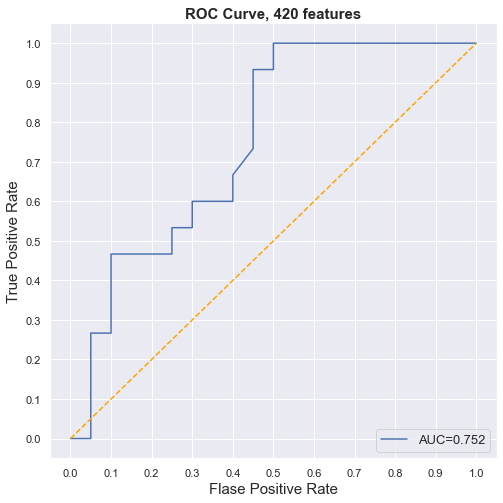

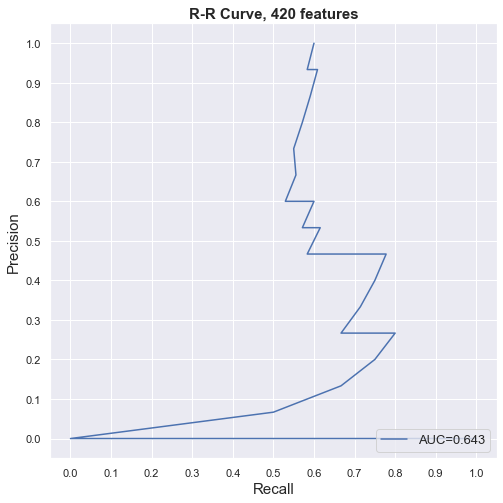

In [41]:
print(pipe_man)
test_score = pipe_man.score(X_test, y_test)
y_pred = pipe_man.predict(X_test)
y_score = [score[1] for score in pipe_man.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {X_test.shape[1]} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {X_test.shape[1]} features")

# 2. No feature selection

In [20]:
name_train, name_test, X_train, y_train, X_test, y_test = split_data(
    df_man.rename(columns={"std_smiles":"smiles"}), 
    ratio=0.7, 
    featurized=True,
    random_state=712,
)
len(X_train), len(y_train), len(X_test), len(y_test)

Spliting training and test data ... Done!
train_1: 38; train_0: 43; test_1: 15; test_0: 20


(81, 81, 35, 35)

In [21]:
pipe_man = _train(X_train, y_train, cv_n_splits=5, grid=grid_light, print_log=False, verbose=10, n_jobs=-1, scoring="accuracy")

Fitting 5 folds for each of 33 candidates, totalling 165 fits
Best model saved to: ../output/model/best_model_20210205-111144.pkl
Best score: 0.7779411764705882


Pipeline(steps=[('sclr', DummyScaler(scaler=StandardScaler())),
                ('clf', MLPClassifier(alpha=0.1, hidden_layer_sizes=10))])
stats
tp: 13.0
fp: 6.0
tn: 14.0
fn: 2.0
score
roc_auc: 0.8033333333333335
accuracy: 0.7714285714285715
precision: 0.6842105263157895
recall: 0.8666666666666667
specificity: 0.7
mcc: 0.5629262517526437


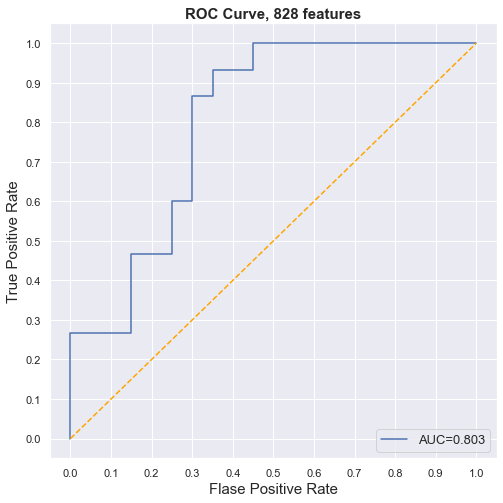

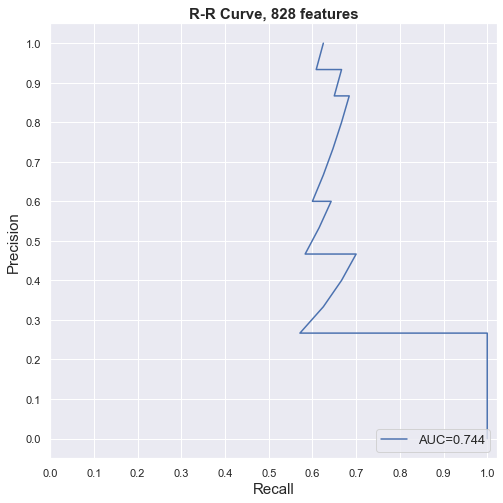

In [22]:
print(pipe_man)
test_score = pipe_man.score(X_test, y_test)
y_pred = pipe_man.predict(X_test)
y_score = [score[1] for score in pipe_man.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {X_test.shape[1]} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {X_test.shape[1]} features")

# 3. RFECV

In [27]:
name_train, name_test, X_train, y_train, X_test, y_test = split_data(
    df_man.rename(columns={"std_smiles":"smiles"}), 
    ratio=0.7, 
    featurized=True,
    random_state=712,
)
len(X_train), len(y_train), len(X_test), len(y_test)

Spliting training and test data ... Done!
train_1: 38; train_0: 43; test_1: 15; test_0: 20


(81, 81, 35, 35)

In [30]:
# pipe = Pipeline(steps=[('sclr', DummyScaler(scaler=StandardScaler())),
#                 ('clf', MLPClassifier(alpha=0.1, hidden_layer_sizes=10))])
selected_feature_rfecv_idx = _rfecv(X_train, y_train, estimator=pipe_man, min_features_to_select=200)
print(len(selected_feature_rfecv_idx), selected_feature_rfecv_idx)

ValueError: when `importance_getter=='auto'`, the underlying estimator Pipeline should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

### Try heavy grid to optimize performance

In [479]:
pipe_man_optimized = _train(X_train, y_train, grid=grid_heavy, verbose=10, n_jobs=-1, scoring="accuracy")

Fitting 10 folds for each of 13692 candidates, totalling 136920 fits
Cross-validation scores                                                                            0      \
mean_fit_time                                                           0.029763   
std_fit_time                                                            0.004592   
mean_score_time                                                         0.005804   
std_score_time                                                          0.000957   
param_clf                                               RandomForestClassifier()   
param_clf__criterion                                                        gini   
param_clf__max_depth                                                           3   
param_clf__max_features                                                 0.100000   
param_clf__min_samples_leaf                                                   10   
param_clf__n_estimators                                            

Pipeline(steps=[('sclr', DummyScaler(scaler=StandardScaler())),
                ('clf',
                 MLPClassifier(alpha=1e-07, hidden_layer_sizes=10,
                               max_iter=1800, solver='lbfgs'))])
stats
tp: 9.0
fp: 9.0
tn: 13.0
fn: 4.0
score
roc_auc: 0.7395104895104895
accuracy: 0.6285714285714286
precision: 0.5
recall: 0.6923076923076923
specificity: 0.5909090909090909
mcc: 0.2738049460812574


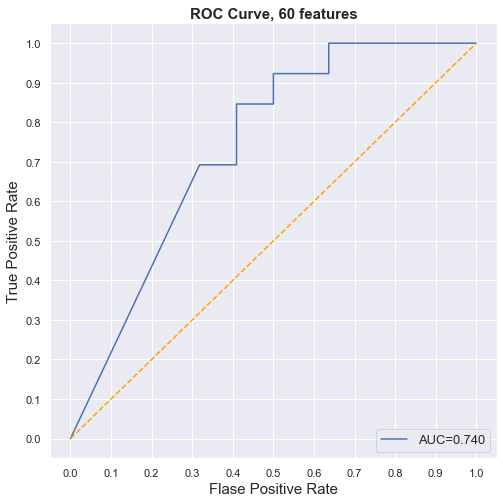

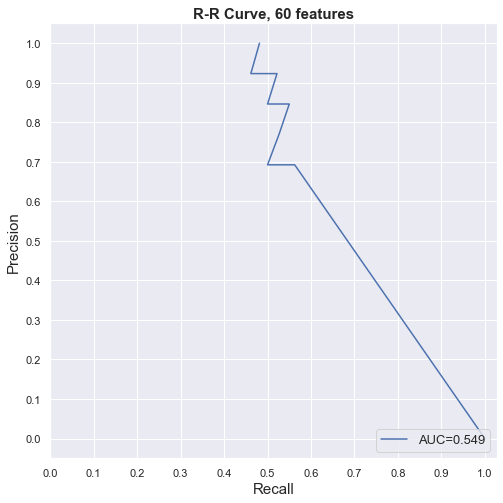

In [480]:
print(pipe_man_optimized)
test_score = pipe_man_optimized.score(X_test, y_test)
y_pred = pipe_man_optimized.predict(X_test)
y_score = [score[1] for score in pipe_man_optimized.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {len(feats_id)} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {len(feats_id)} features")

# 4. Only remove low variance and similar features, test on manual data

In [575]:
df_man

,name,std_smiles,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,rdk_NumAliphaticHeterocycles,...,pychem_ATSe8,pychem_ATSp1,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8,label
0,paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0.446809,62.0,802.510,4.0,15.0,7.0,3.0,1.0,...,5.184,4.058,4.421,4.610,4.691,4.805,4.894,4.829,4.748,1
1,vincristine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.565217,60.0,768.524,3.0,14.0,9.0,1.0,5.0,...,5.159,4.047,4.528,4.759,4.967,4.988,4.985,4.913,4.799,1
2,LTC4,CCCCCC=CCC=CC=CC=CC(SCC(NC(=O)CCC(N)C(=O)O)C(=...,0.566667,43.0,578.409,8.0,12.0,0.0,0.0,0.0,...,4.316,3.625,3.715,3.760,3.789,3.831,3.863,3.902,3.888,1
3,E217bG,CC12CCC3c4ccc(O)cc4CCC3C1CCC2OC1OC(C(=O)O)C(O)...,0.708333,32.0,416.256,5.0,8.0,5.0,3.0,1.0,...,3.811,3.451,3.843,3.915,3.791,3.648,3.590,3.502,3.258,1
4,gemcitabine,Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1,0.555556,18.0,252.112,4.0,7.0,2.0,0.0,1.0,...,1.615,2.614,2.903,2.835,2.645,2.489,2.138,1.619,0.860,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,CCTA-45,O=C(Nc1cccc(-c2cc(F)cc(F)c2)c1)C(Cl)Cl,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,...,2.683,2.987,3.254,3.163,3.045,3.063,2.856,2.604,2.351,0
112,CCTA-46,O=C(Nc1cccc(-c2cc(F)c(F)c(F)c2)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,2.877,3.003,3.278,3.198,3.060,3.078,2.892,2.650,2.399,0
113,CCTA-47,O=C(Nc1cccc(-c2cc(F)ccc2F)c1)C(Cl)Cl,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,...,2.807,2.987,3.254,3.177,3.055,3.067,2.849,2.590,2.365,0
114,CCTA-48,O=C(Nc1cccc(-c2ccc(F)c(F)c2F)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,2.981,3.003,3.278,3.211,3.075,3.078,2.885,2.636,2.412,0


In [576]:
name_train, name_test, X_train, y_train, X_test, y_test = split_data(
    df_man.rename(columns={"std_smiles":"smiles"}), 
    ratio=0.7, 
    featurized=True,
)
len(X_train), len(y_train), len(X_test), len(y_test)

Spliting training and test data ... Done!
train_1: 34; train_0: 47; test_1: 19; test_0: 16


(81, 81, 35, 35)

In [550]:
# make copies for feature selection
# apply feature support to dataframe

X_train_fix, X_test_fix = X_train, X_test

### Scale training, test data

In [551]:
transformer_tr = StandardScaler().fit(X_train)
transformer_te = StandardScaler().fit(X_test)

X_train = transformer_tr.transform(X_train)
X_test = transformer_te.transform(X_test)

X_train, X_test

(array([[-0.77128674, -0.6622057 , -0.55817499, ..., -0.2222499 ,
         -0.38768899, -0.38648088],
        [ 1.68580363,  4.13103641,  4.1562373 , ...,  1.79012693,
          1.85066426,  1.88002143],
        [ 0.85688845,  2.152873  ,  2.07369953, ...,  1.73820146,
          1.65405879,  1.56690965],
        ...,
        [ 0.50245576,  0.55512563,  0.41017287, ...,  0.52484102,
          0.6081177 ,  0.68361421],
        [-0.77128674, -0.6622057 , -0.55817499, ..., -0.30384707,
         -0.30314864, -0.29041249],
        [ 1.01195276, -1.04262174, -1.13065091, ..., -1.35613258,
         -1.61745619, -1.91556937]]),
 array([[ 0.17411444,  0.42973303,  0.40620711, ...,  0.66123847,
          0.7428719 ,  0.78932835],
        [-1.1194069 , -0.69171939, -0.59133973, ..., -0.54242324,
         -0.53778531, -0.53194711],
        [-0.93363522, -0.55978381, -0.335304  , ..., -0.30287096,
         -0.16417209, -0.22830598],
        ...,
        [-0.99555911,  0.49570082,  0.45551197, ...,  

In [552]:
X_train.shape, X_test.shape

((81, 828), (35, 828))

### Remove similar features

Training data

In [553]:
support_similar, X_train = _remove_similar_features(X_train)
X_train.shape

Calculating correlation matrix ... Done!
Creating correlation graph ... Done!


(81, 421)

In [554]:
support_similar

array([  0,   7,   8,  15,  16,  17,  18,  19,  22,  23,  24,  25,  30,
        33,  34,  35,  37,  39,  40,  41,  42,  43,  44,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  61,  64,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  82,  83,
        84,  85,  87,  88,  90,  91,  92,  93,  94,  95,  97,  98, 100,
       102, 103, 104, 105, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 133, 138, 160, 162, 163, 164, 165, 173, 174, 175, 184, 190,
       192, 193, 197, 213, 214, 216, 217, 228, 245, 246, 250, 257, 263,
       271, 276, 277, 278, 279, 291, 295, 298, 302, 303, 304, 310, 319,
       325, 326, 327, 335, 343, 351, 359, 374, 384, 385, 388, 390, 391,
       392, 397, 398, 399, 400, 401, 402, 405, 407, 409, 410, 412, 413,
       415, 416, 418, 419, 420, 423, 426, 429, 432, 435, 436, 437, 438,
       439, 440, 441, 443, 444, 451, 452, 453, 454, 455, 456, 457, 458,
       459, 460, 461, 462, 463, 464, 465, 467, 468, 469, 470, 47

In [555]:
X_train = X_train.values

Test data

In [556]:
X_test = X_test[:, support_similar]
type(X_test), X_test.shape

(numpy.ndarray, (35, 421))

### Remove low variance features

Training data

In [557]:
support_lowvar, X_train = _remove_low_variance_features(X_train)
X_train.shape

(81, 258)

In [558]:
support_lowvar

array([  0,   1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,
        16,  17,  18,  19,  20,  23,  24,  25,  27,  28,  32,  34,  37,
        40,  44,  45,  47,  48,  53,  54,  55,  56,  57,  60,  62,  63,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  83,  84,  85,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 137, 138,
       139, 141, 142, 143, 147, 149, 151, 190, 191, 192, 193, 195, 196,
       198, 201, 202, 204, 205, 206, 207, 208, 217, 220, 221, 222, 223,
       224, 240, 245, 256, 257, 258, 259, 260, 262, 263, 264, 265, 266,
       272, 273, 274, 275, 276, 286, 310, 311, 312, 313, 314, 315, 316,
       317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
       330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 34

Test data

In [559]:
X_test = X_test[:, support_lowvar]

In [560]:
X_test.shape

(35, 258)

In [561]:
X_train = X_train_fix.iloc[:, support_similar].iloc[:, support_lowvar]
X_test = X_test_fix.iloc[:, support_similar].iloc[:, support_lowvar]
print(X_train.shape, X_test.shape)

(81, 258) (35, 258)


(     rdk_FractionCSP3  rdk_NumAliphaticHeterocycles  rdk_NumAliphaticRings  \
 99           0.187500                           0.0                    0.0   
 45           0.790323                           1.0                    1.0   
 8            0.586957                           5.0                    6.0   
 98           0.187500                           0.0                    0.0   
 83           0.105263                           0.0                    0.0   
 ..                ...                           ...                    ...   
 31           0.923077                           0.0                    4.0   
 20           0.200000                           1.0                    1.0   
 13           0.500000                           0.0                    0.0   
 100          0.187500                           0.0                    0.0   
 47           0.625000                           1.0                    1.0   
 
      rdk_NumRotatableBonds  rdk_NumSaturatedCarbo

### Train model

In [562]:
# check feature name
type(X_train)

pandas.core.frame.DataFrame

In [42]:
grid_light_balance = [
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [100, 1000],
        "clf__class_weight": [{0: 0.9, 1: 0.1}, {0: 0.99, 1: 0.01}],
        "sclr": [StandardScaler()],
    },
    {
        "clf": [XGBClassifier()],
        "clf__n_estimators": [100, 1000],
        "clf__scale_pos_weight": [1, 10, 100, 1000],
    },
    {
        "clf": [SVC(probability=True)],
        "clf__kernel": ["rbf", "linear"],
        "clf__class_weight": [{0: 0.9, 1: 0.1}, {0: 0.99, 1: 0.01}],
        "sclr": [StandardScaler()],
    },
#     {
#         "clf": [MLPClassifier()],
#         "clf__solver": ["lbfgs"],
#         "clf__max_iter": [1000, 2000],
#         "clf__alpha": [0.1, 1],
#         "clf__hidden_layer_sizes": [10, 15],
#         "sclr__scaler": [StandardScaler()],
#     },
]

In [564]:
pipe_man = _train(X_train, y_train, grid=grid_light_balance, verbose=10, n_jobs=-1, scoring="accuracy")

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Cross-validation scores                                                                               0   \
mean_fit_time                                                           0.229039   
std_fit_time                                                            0.005194   
mean_score_time                                                         0.022313   
std_score_time                                                          0.002202   
param_clf                              RandomForestClassifier(n_estimators=1000)   
param_clf__n_estimators                                                      100   
param_sclr                                                      StandardScaler()   
param_clf__kernel                                                            NaN   
param_clf__alpha                                                             NaN   
param_clf__hidden_layer_sizes                                            

Pipeline(steps=[('sclr', StandardScaler()),
                ('clf', RandomForestClassifier(n_estimators=1000))])
stats
tp: 13.0
fp: 5.0
tn: 14.0
fn: 3.0
score
roc_auc: 0.8108552631578948
accuracy: 0.7714285714285715
precision: 0.7222222222222222
recall: 0.8125
specificity: 0.7368421052631579
mcc: 0.547543926607891


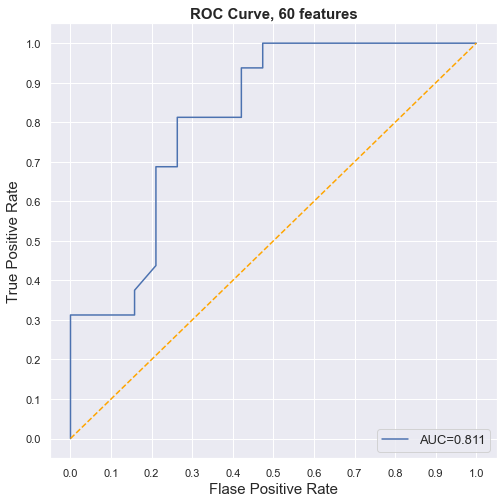

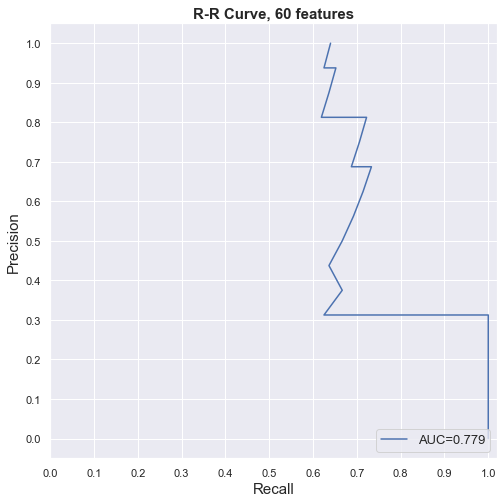

In [565]:
print(pipe_man)
test_score = pipe_man.score(X_test, y_test)
y_pred = pipe_man.predict(X_test)
y_score = [score[1] for score in pipe_man.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {len(feats_id)} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {len(feats_id)} features")

# 4. Only remove low variance and similar features, test on manual data

In [633]:
df_man

,name,smiles,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,rdk_NumAliphaticHeterocycles,...,pychem_ATSe8,pychem_ATSp1,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8,label
0,paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0.446809,62.0,802.510,4.0,15.0,7.0,3.0,1.0,...,5.184,4.058,4.421,4.610,4.691,4.805,4.894,4.829,4.748,1
1,vincristine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.565217,60.0,768.524,3.0,14.0,9.0,1.0,5.0,...,5.159,4.047,4.528,4.759,4.967,4.988,4.985,4.913,4.799,1
2,LTC4,CCCCCC=CCC=CC=CC=CC(SCC(NC(=O)CCC(N)C(=O)O)C(=...,0.566667,43.0,578.409,8.0,12.0,0.0,0.0,0.0,...,4.316,3.625,3.715,3.760,3.789,3.831,3.863,3.902,3.888,1
3,E217bG,CC12CCC3c4ccc(O)cc4CCC3C1CCC2OC1OC(C(=O)O)C(O)...,0.708333,32.0,416.256,5.0,8.0,5.0,3.0,1.0,...,3.811,3.451,3.843,3.915,3.791,3.648,3.590,3.502,3.258,1
4,gemcitabine,Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1,0.555556,18.0,252.112,4.0,7.0,2.0,0.0,1.0,...,1.615,2.614,2.903,2.835,2.645,2.489,2.138,1.619,0.860,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,CCTA-45,O=C(Nc1cccc(-c2cc(F)cc(F)c2)c1)C(Cl)Cl,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,...,2.683,2.987,3.254,3.163,3.045,3.063,2.856,2.604,2.351,0
112,CCTA-46,O=C(Nc1cccc(-c2cc(F)c(F)c(F)c2)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,2.877,3.003,3.278,3.198,3.060,3.078,2.892,2.650,2.399,0
113,CCTA-47,O=C(Nc1cccc(-c2cc(F)ccc2F)c1)C(Cl)Cl,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,...,2.807,2.987,3.254,3.177,3.055,3.067,2.849,2.590,2.365,0
114,CCTA-48,O=C(Nc1cccc(-c2ccc(F)c(F)c2F)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,2.981,3.003,3.278,3.211,3.075,3.078,2.885,2.636,2.412,0


In [638]:
name_train, name_test, X_train, y_train, X_test, y_test = split_data(
    df_man.rename(columns={"std_smiles":"smiles"}), 
    ratio=0.7, 
    featurized=True,
    random_state=712,
)
len(X_train), len(y_train), len(X_test), len(y_test)

Spliting training and test data ... Done!
train_1: 38; train_0: 43; test_1: 15; test_0: 20


(81, 81, 35, 35)

In [639]:
X_train_fix, X_test_fix = X_train, X_test

In [640]:
support_similar, X_train = _remove_similar_features(X_train)
X_train.shape

Calculating correlation matrix ... Done!
Creating correlation graph ... Done!


(81, 420)

In [641]:
len(support_similar), support_similar

(420,
 array([  0,   6,   7,  11,  15,  16,  18,  19,  23,  24,  25,  29,  33,
         34,  35,  37,  39,  41,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  61,  62,  64,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  82,  83,
         84,  85,  87,  88,  90,  91,  92,  93,  94,  95,  97,  98, 100,
        101, 102, 103, 104, 105, 130, 133, 138, 156, 162, 163, 164, 165,
        168, 173, 174, 175, 178, 184, 190, 192, 193, 197, 199, 213, 214,
        228, 245, 246, 250, 257, 259, 263, 271, 274, 278, 279, 291, 295,
        300, 301, 302, 303, 319, 325, 326, 327, 343, 351, 359, 366, 367,
        374, 385, 386, 389, 390, 391, 392, 397, 398, 399, 400, 401, 402,
        405, 407, 410, 412, 413, 415, 416, 418, 419, 420, 422, 423, 425,
        426, 429, 435, 436, 437, 438, 439, 440, 441, 443, 444, 451, 452,
        453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
        467, 468, 469, 470, 472, 473, 474, 47

In [642]:
X_train = X_train_fix.iloc[:, support_similar]
X_test = X_test_fix.iloc[:, support_similar]
print(X_train.shape, X_test.shape)

(81, 420) (35, 420)


In [645]:
grid = [
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [10, 100, 500, 1000],
        "clf__criterion": ["gini", "entropy"],
        "clf__max_depth": [3, 5, 7],
        "clf__min_samples_leaf": [10, 50, 100, 500, 1000],
        "clf__max_features": [0.1, 0.5, 1.0, "sqrt", "log2"],
        "sclr__scaler": [StandardScaler()],
    },
    {
        "clf": [XGBClassifier()],
        "clf__min_child_weight": [1, 5],
        "clf__gamma": [0, 1, 5],
        "clf__subsample": [0.6, 0.8, 1.0],
        "clf__colsample_bytree": [0.4, 0.7, 1.0],
        "clf__learning_rate": [0.001, 0.01, 0.1, 0.3, 0.5],
        "clf__max_depth": [4, 5, 7],
        "clf__n_estimators": [100, 500, 1000],
        "clf__scale_pos_weight": [10, 100, 1000],
    },
    {
        "clf": [SVC(probability=True)],
        "clf__kernel": ["rbf"],
        "clf__C": [1, 10, 100, 1000],
        "clf__gamma": [1e-3, 1e-4],
        "sclr__scaler": [StandardScaler()],
    },
    {
        "clf": [SVC(probability=True)],
        "clf__kernel": ["linear"],
        "clf__C": [1, 10, 100, 1000],
        "sclr__scaler": [StandardScaler()],
    },
    {
        "clf": [MLPClassifier()],
        "clf__solver": ["lbfgs"],
        "clf__max_iter": [1000, 1200, 1400, 1600, 1800, 2000],
        "clf__alpha": 10.0 ** -np.arange(1, 10, 2),
        "clf__hidden_layer_sizes": np.arange(10, 15),
        "sclr__scaler": [StandardScaler()],
    },
]

In [643]:
pipe_man = _train(X_train, y_train, grid=grid_light_balance, cv_n_splits=10, verbose=10, n_jobs=-1, scoring="precision")

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Cross-validation scores                                                                               0   \
mean_fit_time                                                           0.221528   
std_fit_time                                                            0.005584   
mean_score_time                                                         0.023573   
std_score_time                                                          0.001019   
param_clf                              RandomForestClassifier(n_estimators=1000)   
param_clf__n_estimators                                                      100   
param_sclr                                                      StandardScaler()   
param_clf__kernel                                                            NaN   
param_clf__alpha                                                             NaN   
param_clf__hidden_layer_sizes                                            

Pipeline(steps=[('sclr', DummyScaler(scaler=StandardScaler())),
                ('clf',
                 MLPClassifier(alpha=1, hidden_layer_sizes=10, max_iter=1000,
                               solver='lbfgs'))])
stats
tp: 13.0
fp: 7.0
tn: 13.0
fn: 2.0
score
roc_auc: 0.7733333333333334
accuracy: 0.7428571428571429
precision: 0.65
recall: 0.8666666666666667
specificity: 0.65
mcc: 0.5166666666666667


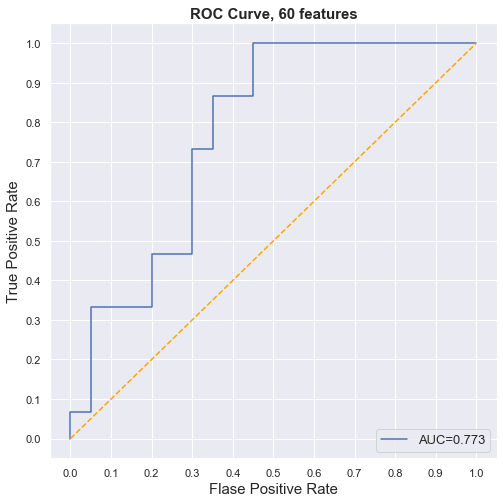

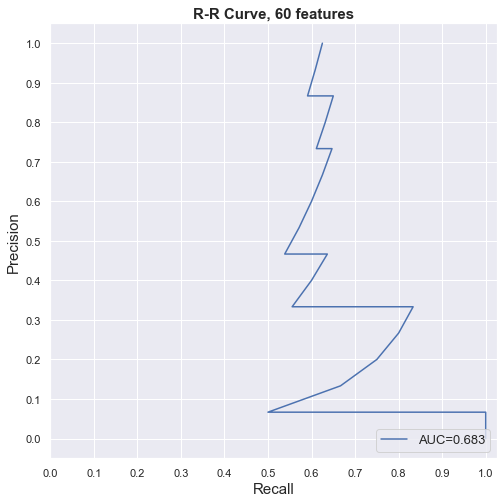

In [644]:
print(pipe_man)
test_score = pipe_man.score(X_test, y_test)
y_pred = pipe_man.predict(X_test)
y_score = [score[1] for score in pipe_man.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {len(feats_id)} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {len(feats_id)} features")

In [646]:
pipe_man_optimal = _train(X_train, y_train, grid=grid, cv_n_splits=5, verbose=10, n_jobs=-1, scoring="precision")

Fitting 5 folds for each of 8052 candidates, totalling 40260 fits
Cross-validation scores                                                                             0     \
mean_fit_time                                                           0.022545   
std_fit_time                                                            0.001812   
mean_score_time                                                         0.006716   
std_score_time                                                          0.001075   
param_clf                      RandomForestClassifier(criterion='entropy', ma...   
param_clf__criterion                                                        gini   
param_clf__max_depth                                                           3   
param_clf__max_features                                                 0.100000   
param_clf__min_samples_leaf                                                   10   
param_clf__n_estimators                                               

Pipeline(steps=[('sclr', DummyScaler(scaler=StandardScaler())),
                ('clf',
                 RandomForestClassifier(criterion='entropy', max_depth=3,
                                        max_features='sqrt',
                                        min_samples_leaf=10,
                                        n_estimators=10))])
stats
tp: 12.0
fp: 8.0
tn: 12.0
fn: 3.0
score
roc_auc: 0.73
accuracy: 0.6857142857142857
precision: 0.6
recall: 0.8
specificity: 0.6
mcc: 0.4


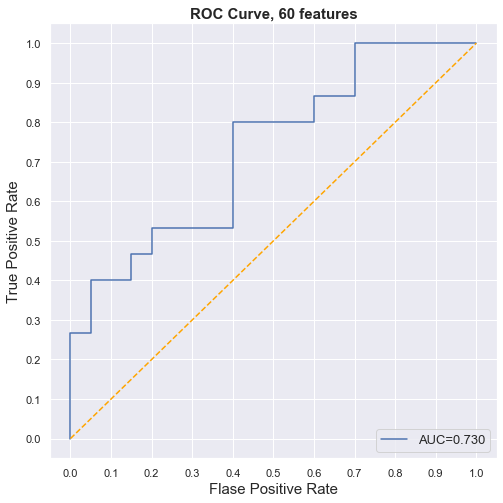

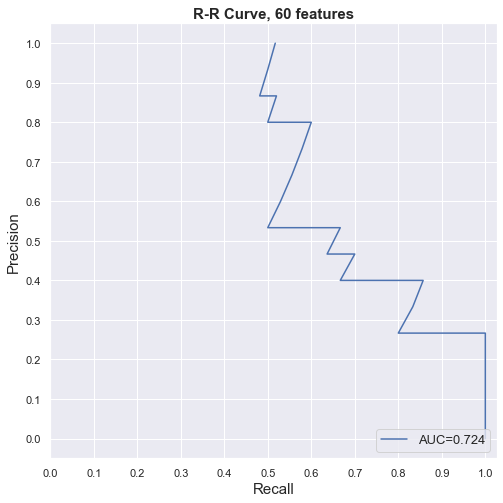

In [647]:
print(pipe_man_optimal)
test_score = pipe_man_optimal.score(X_test, y_test)
y_pred = pipe_man_optimal.predict(X_test)
y_score = [score[1] for score in pipe_man_optimal.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {len(feats_id)} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {len(feats_id)} features")

# 5. Give more weights to negative data

In [61]:
grid_light_balance = [
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [100, 1000],
        "clf__class_weight": [{0: 0.9, 1: 0.1}, {0: 0.99, 1: 0.01}],
        "sclr": [StandardScaler()],
    },
    {
        "clf": [XGBClassifier()],
        "clf__n_estimators": [100, 1000],
        "clf__scale_pos_weight": [1, 10, 100, 1000],
    },
    {
        "clf": [SVC(probability=True)],
        "clf__kernel": ["rbf", "linear"],
        "clf__class_weight": [{0: 0.9, 1: 0.1}, {0: 0.99, 1: 0.01}],
        "sclr": [StandardScaler()],
    },
]

In [62]:
name_train, name_test, X_train, y_train, X_test, y_test = split_data(
    df_man.rename(columns={"std_smiles":"smiles"}), 
    ratio=0.7, 
    featurized=True,
    random_state=712,
)
len(X_train), len(y_train), len(X_test), len(y_test), X_train.shape

Spliting training and test data ... Done!
train_1: 38; train_0: 43; test_1: 15; test_0: 20


(81, 81, 35, 35, (81, 828))

In [63]:
support_similar, X_train = _remove_similar_features(X_train, threshold=0.95)
len(support_similar), support_similar

Calculating correlation matrix ... Done!
Creating correlation graph ... Done!


(475,
 array([  0,   6,   7,   8,   9,  10,  15,  16,  17,  18,  19,  22,  23,
         24,  25,  26,  30,  32,  33,  34,  35,  36,  37,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
         56,  57,  58,  59,  61,  64,  67,  68,  69,  70,  71,  72,  73,
         74,  75,  76,  77,  78,  82,  83,  84,  85,  87,  88,  90,  91,
         92,  93,  94,  95,  96,  97,  98, 100, 101, 102, 103, 104, 105,
        132, 133, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
        153, 154, 156, 162, 163, 164, 165, 166, 167, 168, 173, 174, 175,
        176, 186, 189, 191, 192, 193, 194, 195, 197, 200, 209, 211, 213,
        214, 216, 217, 228, 235, 245, 246, 249, 250, 254, 257, 259, 263,
        271, 274, 278, 279, 280, 291, 292, 295, 298, 299, 300, 301, 302,
        303, 310, 319, 325, 326, 327, 350, 351, 357, 358, 359, 363, 364,
        365, 366, 367, 372, 374, 375, 383, 384, 385, 386, 389, 390, 391,
        392, 395, 397, 398, 399, 400, 401, 40

In [64]:
X_test = X_test.iloc[:, support_similar]
print(X_train.shape, X_test.shape)

(81, 475) (35, 475)


In [57]:
pipe_man = _train(X_train, y_train, grid=grid_light_balance, cv_n_splits=10, verbose=10, n_jobs=-1, scoring="accuracy", print_log=False)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best model saved to: ../output/model/best_model_20210206-135046.pkl
Best score: 0.7763888888888889


Pipeline(steps=[('sclr', StandardScaler()),
                ('clf',
                 RandomForestClassifier(class_weight={0: 0.99, 1: 0.01}))])
stats
tp: 14.0
fp: 9.0
tn: 11.0
fn: 1.0
score
roc_auc: 0.8366666666666667
accuracy: 0.7142857142857143
precision: 0.6086956521739131
recall: 0.9333333333333333
specificity: 0.55
mcc: 0.503909833971264


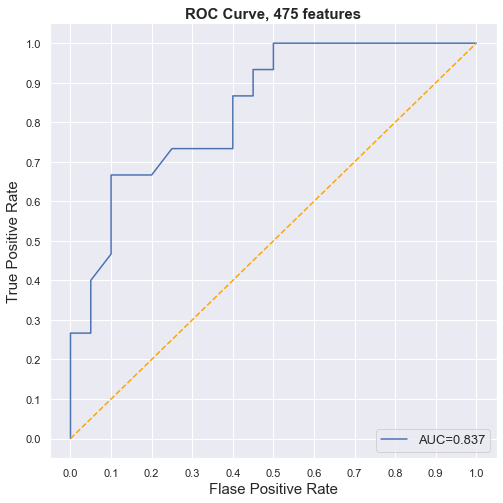

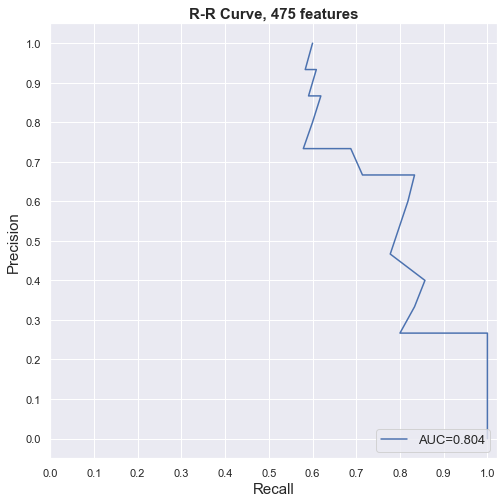

In [67]:
print(pipe_man)
test_score = pipe_man.score(X_test, y_test)
y_pred = pipe_man.predict(X_test)
y_score = [score[1] for score in pipe_man.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {X_test.shape[1]} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {X_test.shape[1]} features")

# 6. Give more weights to negative data, score = precision, threshold = 0.95

In [69]:
name_train, name_test, X_train, y_train, X_test, y_test = split_data(
    df_man.rename(columns={"std_smiles":"smiles"}), 
    ratio=0.7, 
    featurized=True,
    random_state=712,
)
len(X_train), len(y_train), len(X_test), len(y_test), X_train.shape

Spliting training and test data ... Done!
train_1: 38; train_0: 43; test_1: 15; test_0: 20


(81, 81, 35, 35, (81, 828))

In [70]:
support_similar, X_train = _remove_similar_features(X_train, threshold=0.95)
len(support_similar), support_similar

Calculating correlation matrix ... Done!
Creating correlation graph ... Done!


(475,
 array([  0,   6,   7,   8,   9,  10,  15,  16,  17,  18,  19,  22,  23,
         24,  25,  26,  30,  32,  33,  34,  35,  36,  37,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
         56,  57,  58,  59,  61,  64,  67,  68,  69,  70,  71,  72,  73,
         74,  75,  76,  77,  78,  82,  83,  84,  85,  87,  88,  90,  91,
         92,  93,  94,  95,  96,  97,  98, 100, 101, 102, 103, 104, 105,
        132, 133, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
        153, 154, 156, 162, 163, 164, 165, 166, 167, 168, 173, 174, 175,
        176, 186, 189, 191, 192, 193, 194, 195, 197, 200, 209, 211, 213,
        214, 216, 217, 228, 235, 245, 246, 249, 250, 254, 257, 259, 263,
        271, 274, 278, 279, 280, 291, 292, 295, 298, 299, 300, 301, 302,
        303, 310, 319, 325, 326, 327, 350, 351, 357, 358, 359, 363, 364,
        365, 366, 367, 372, 374, 375, 383, 384, 385, 386, 389, 390, 391,
        392, 395, 397, 398, 399, 400, 401, 40

In [72]:
X_test = X_test.iloc[:, support_similar]
print(X_train.shape, X_test.shape)

(81, 475) (35, 475)


In [76]:
pipe_man = _train(X_train, y_train, grid=grid_light_balance, cv_n_splits=10, verbose=10, n_jobs=-1, scoring="precision", print_log=False)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best model saved to: ../output/model/best_model_20210206-141413.pkl
Best score: 0.8233333333333333


Pipeline(steps=[('sclr', StandardScaler()),
                ('clf',
                 SVC(class_weight={0: 0.99, 1: 0.01}, kernel='linear',
                     probability=True))])
stats
tp: 12.0
fp: 7.0
tn: 13.0
fn: 3.0
score
roc_auc: 0.8033333333333333
accuracy: 0.7142857142857143
precision: 0.631578947368421
recall: 0.8
specificity: 0.65
mcc: 0.4470296705094523


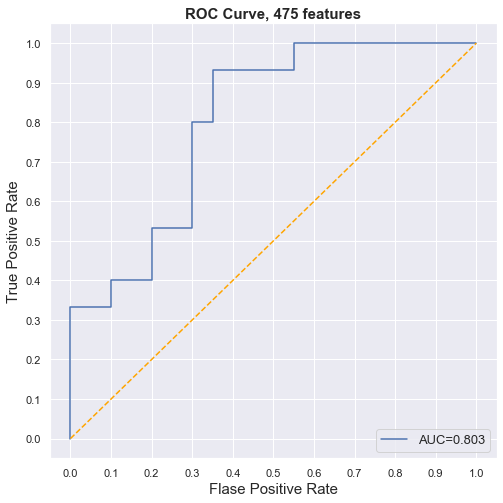

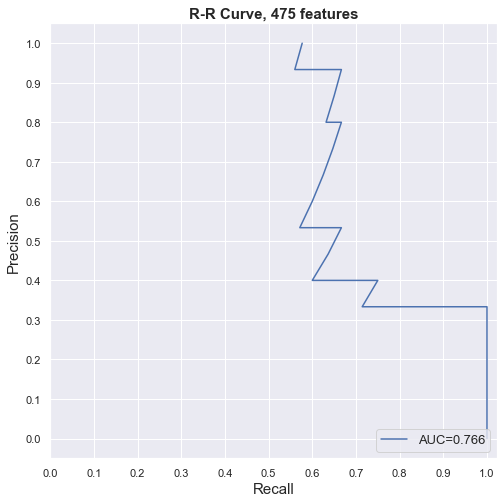

In [77]:
print(pipe_man)
test_score = pipe_man.score(X_test, y_test)
y_pred = pipe_man.predict(X_test)
y_score = [score[1] for score in pipe_man.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {X_test.shape[1]} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {X_test.shape[1]} features")

# 7. Give much more weights to negative data, score = precision, threshold = 0.99



In [28]:
grid_light_balance_7 = [
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [100, 1000],
        "clf__class_weight": [{0: 0.999, 1: 0.001}, {0: 0.99, 1: 0.01}],
        "sclr": [StandardScaler()],
    },
    {
        "clf": [XGBClassifier()],
        "clf__n_estimators": [100, 1000],
        "clf__scale_pos_weight": [1, 10, 100, 1000],
        "clf__learning_rate": [0.01, 0.1, 0.5, 1],
    },
    {
        "clf": [SVC(probability=True)],
        "clf__kernel": ["rbf", "linear"],
        "clf__class_weight": [{0: 0.999, 1: 0.001}, {0: 0.99, 1: 0.01}],
        "sclr": [StandardScaler()],
    },
]

In [29]:
name_train, name_test, X_train, y_train, X_test, y_test = split_data(
    df_man.rename(columns={"std_smiles":"smiles"}), 
    ratio=0.7, 
    featurized=True,
    random_state=712,
)
len(X_train), len(y_train), len(X_test), len(y_test), X_train.shape

Spliting training and test data ... Done!
train_1: 39; train_0: 42; test_1: 14; test_0: 21


(81, 81, 35, 35, (81, 828))

In [30]:
support_similar, X_train = _remove_similar_features(X_train, threshold=0.99)
len(support_similar), support_similar

Calculating correlation matrix ... Done!
Creating correlation graph ... Done!


(610,
 array([  0,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,  15,
         17,  18,  19,  21,  22,  23,  24,  25,  26,  29,  31,  32,  33,
         34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
         47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
         61,  62,  64,  65,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  82,  83,  84,  85,  87,  88,  90,  91,  92,  93,
         94,  95,  96,  97,  98, 100, 101, 102, 103, 104, 105, 106, 107,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 132, 133, 156, 157, 158, 159, 160, 161, 162, 173, 174, 175,
        176, 189, 191, 192, 193, 194, 195, 197, 198, 206, 209, 210, 212,
        215, 216, 225, 227, 228, 231, 235, 236, 237, 240, 241, 242, 244,
        245, 246, 247, 248, 249, 250, 251, 254, 255, 256, 257, 258, 259,
        260, 263, 265, 266, 271, 273, 274, 275, 276, 277, 278, 279, 280,
        282, 290, 292, 293, 294, 295, 296, 29

In [31]:
X_test = X_test.iloc[:, support_similar]
print(X_train.shape, X_test.shape)

(81, 610) (35, 610)


In [32]:
pipe_man = _train(X_train, y_train, grid=grid_light_balance_7, cv_n_splits=40, verbose=10, n_jobs=-1, scoring="precision", print_log=False)

Fitting 40 folds for each of 40 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

[02:41:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best model saved to: ../output/model/best_model_20210211-024121.pkl
Best score: 0.7625


Pipeline(steps=[('sclr', DummyScaler()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=100,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])
stats
tp: 13.0
fp: 9.0
tn: 12.0
fn: 1.0
score
roc_auc: 0.7431972789115646
accuracy: 0.71428571

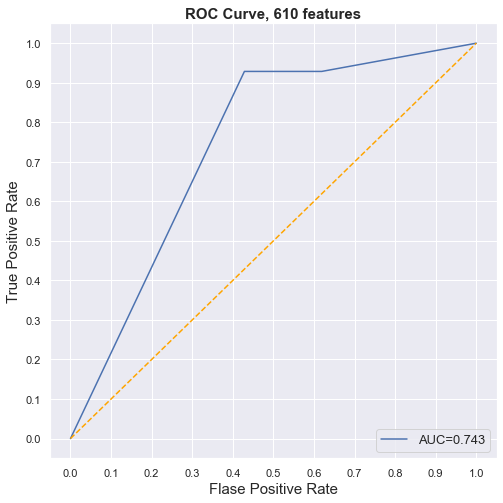

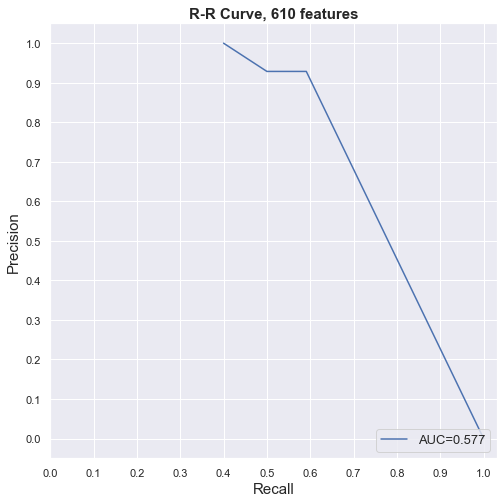

In [33]:
print(pipe_man)
test_score = pipe_man.score(X_test, y_test)
y_pred = pipe_man.predict(X_test)
y_score = [score[1] for score in pipe_man.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {X_test.shape[1]} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {X_test.shape[1]} features")

# Split data by scaffold

In [5]:
import deepchem as dc

In [ ]:
splitter = dc.splits.ScaffoldSplitter()
molecules = df_man["smiles"]
train, val, test = splitter.split(molecules, )

# Training / Test = 0.8

similar threshold = 0.99, stratifiedkfold: n_split=10from sklearn.model_selection import StratifiedKFold


In [18]:
name_train, name_test, X_train, y_train, X_test, y_test = split_data(
    df_man.rename(columns={"std_smiles":"smiles"}), 
    ratio=0.8, 
    featurized=True,
    random_state=712,
)
support_similar, X_train = _remove_similar_features(X_train, threshold=0.99)
X_test = X_test.iloc[:, support_similar]

Spliting training and test data ... Done!
train_1: 42; train_0: 50; test_1: 11; test_0: 13
Calculating correlation matrix ... Done!
Creating correlation graph ... Done!


In [19]:
pipe_man = _train(
    X_train, 
    y_train, 
    grid=grid_light_balance_7, 
    cv_n_splits=10, 
    verbose=10, 
    n_jobs=-1, 
    scoring="precision", 
    print_log=False
)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

Best model saved to: ../output/model/best_model_20210208-224145.pkl
Best score: 0.7680952380952382


Pipeline(steps=[('sclr', StandardScaler()),
                ('clf',
                 RandomForestClassifier(class_weight={0: 0.999, 1: 0.001}))])
stats
tp: 10.0
fp: 4.0
tn: 9.0
fn: 1.0
score
roc_auc: 0.9090909090909092
accuracy: 0.7916666666666666
precision: 0.7142857142857143
recall: 0.9090909090909091
specificity: 0.6923076923076923
mcc: 0.6078080037565888


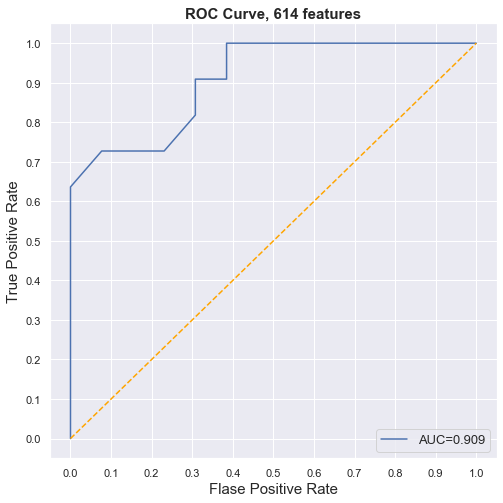

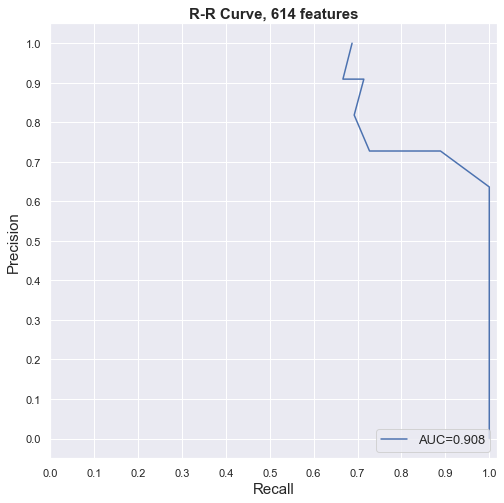

In [20]:
print(pipe_man)
test_score = pipe_man.score(X_test, y_test)
y_pred = pipe_man.predict(X_test)
y_score = [score[1] for score in pipe_man.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {X_test.shape[1]} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {X_test.shape[1]} features")

In [21]:
support_similar

array([  0,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,  15,
        17,  18,  19,  21,  22,  23,  24,  25,  26,  29,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        61,  62,  64,  65,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  81,  82,  83,  84,  85,  87,  88,  90,  91,  92,
        93,  94,  95,  96,  97,  98, 100, 101, 102, 103, 104, 105, 106,
       107, 132, 133, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 189, 190, 191, 192, 193, 197, 198, 202, 203, 206, 209,
       210, 212, 215, 216, 225, 227, 228, 229, 235, 236, 237, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 254, 255, 256,
       257, 258, 259, 260, 263, 264, 267, 268, 272, 273, 274, 27

# Give positive more weight?

Use grid_light_balance_8 

In [22]:
grid_light_balance_8 = [
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [100, 1000],
        "clf__class_weight": [{1: 0.999, 0: 0.001}, {1: 0.99, 0: 0.01}],
        "sclr": [StandardScaler()],
    },
    {
        "clf": [XGBClassifier()],
        "clf__n_estimators": [100, 1000],
        "clf__scale_pos_weight": [1, 10, 100, 1000],
        "clf__learning_rate": [0.01, 0.1, 0.5, 1],
    },
    {
        "clf": [SVC(probability=True)],
        "clf__kernel": ["rbf", "linear"],
        "clf__class_weight": [{1: 0.999, 0: 0.001}, {1: 0.99, 0: 0.01}],
        "sclr": [StandardScaler()],
    },
]

In [23]:
name_train, name_test, X_train, y_train, X_test, y_test = split_data(
    df_man.rename(columns={"std_smiles":"smiles"}), 
    ratio=0.8, 
    featurized=True,
    random_state=712,
)
support_similar, X_train = _remove_similar_features(X_train, threshold=0.99)
X_test = X_test.iloc[:, support_similar]

Spliting training and test data ... Done!
train_1: 42; train_0: 50; test_1: 11; test_0: 13
Calculating correlation matrix ... Done!
Creating correlation graph ... Done!


In [24]:
pipe_man = _train(
    X_train, 
    y_train, 
    grid=grid_light_balance_8, 
    cv_n_splits=10, 
    verbose=10, 
    n_jobs=-1, 
    scoring="precision", 
    print_log=False
)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

Best model saved to: ../output/model/best_model_20210208-230344.pkl
Best score: 0.7683333333333333


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.3min finished


Pipeline(steps=[('sclr', StandardScaler()),
                ('clf',
                 SVC(class_weight={0: 0.01, 1: 0.99}, kernel='linear',
                     probability=True))])
stats
tp: 10.0
fp: 7.0
tn: 6.0
fn: 1.0
score
roc_auc: 0.7062937062937062
accuracy: 0.6666666666666666
precision: 0.5882352941176471
recall: 0.9090909090909091
specificity: 0.46153846153846156
mcc: 0.40628835067443575


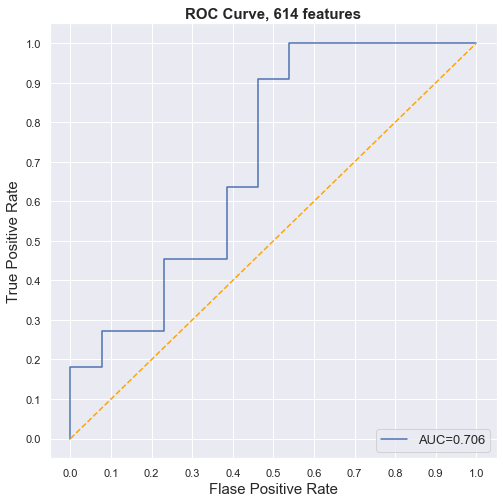

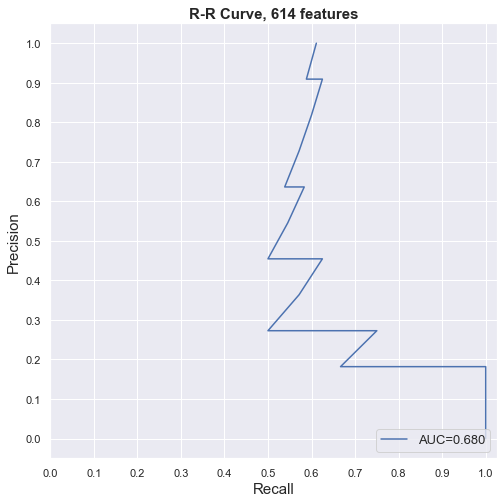

In [25]:
print(pipe_man)
test_score = pipe_man.score(X_test, y_test)
y_pred = pipe_man.predict(X_test)
y_score = [score[1] for score in pipe_man.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {X_test.shape[1]} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {X_test.shape[1]} features")

# Equal weights, new data 0211

cv=5

Pipeline(steps=[('sclr', StandardScaler()),
                ('clf', SVC(gamma=0.001, kernel='linear', probability=True))])
stats
tp: 11.0
fp: 8.0
tn: 13.0
fn: 3.0

score
roc_auc: 0.7517006802721089
accuracy: 0.6857142857142857
precision: 0.5789473684210527
recall: 0.7857142857142857
specificity: 0.6190476190476191
mcc: 0.39804896992221994

cv=10

Pipeline(steps=[('sclr', StandardScaler()),
                ('clf', SVC(gamma=0.001, kernel='linear', probability=True))])
stats
tp: 11.0
fp: 8.0
tn: 13.0
fn: 3.0

score
roc_auc: 0.7517006802721089
accuracy: 0.6857142857142857
precision: 0.5789473684210527
recall: 0.7857142857142857
specificity: 0.6190476190476191
mcc: 0.39804896992221994

cv=20

Pipeline(steps=[('sclr', StandardScaler()),
                ('clf', SVC(gamma=0.001, kernel='linear', probability=True))])
stats
tp: 11.0
fp: 8.0
tn: 13.0
fn: 3.0

score
roc_auc: 0.7517006802721089
accuracy: 0.6857142857142857
precision: 0.5789473684210527
recall: 0.7857142857142857
specificity: 0.6190476190476191
mcc: 0.39804896992221994

cv=38 (leave-one-out)

Pipeline(steps=[('sclr', StandardScaler()),
                ('clf', SVC(gamma=0.001, probability=True))])
stats
tp: 14.0
fp: 11.0
tn: 10.0
fn: 0.0

score
roc_auc: 0.7653061224489796
accuracy: 0.6857142857142857
precision: 0.56
recall: 1.0
specificity: 0.47619047619047616
mcc: 0.5163977794943223

In [34]:
grid_light_equal = [
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [100, 1000],
        "sclr": [StandardScaler()],
    },
    {
        "clf": [XGBClassifier()],
        "clf__n_estimators": [100, 1000],
        "clf__learning_rate": [0.01, 0.1, 0.5, 1],
    },
    {
        "clf": [SVC(probability=True)],
        "clf__kernel": ["rbf", "linear"],
        "clf__gamma": [1e-3, 1e-4],
        "sclr": [StandardScaler()],
    },
]

In [35]:
name_train, name_test, X_train, y_train, X_test, y_test = split_data(
    df_man.rename(columns={"std_smiles":"smiles"}), 
    ratio=0.7, 
    featurized=True,
    random_state=712,
)
len(X_train), len(y_train), len(X_test), len(y_test), X_train.shape

Spliting training and test data ... Done!
train_1: 39; train_0: 42; test_1: 14; test_0: 21


(81, 81, 35, 35, (81, 828))

In [36]:
support_similar, X_train = _remove_similar_features(X_train, threshold=0.99)
len(support_similar), support_similar

Calculating correlation matrix ... Done!
Creating correlation graph ... Done!


(610,
 array([  0,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,  15,
         17,  18,  19,  21,  22,  23,  24,  25,  26,  29,  31,  32,  33,
         34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
         47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
         61,  62,  64,  65,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  82,  83,  84,  85,  87,  88,  90,  91,  92,  93,
         94,  95,  96,  97,  98, 100, 101, 102, 103, 104, 105, 106, 107,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 132, 133, 156, 157, 158, 159, 160, 161, 162, 173, 174, 175,
        176, 189, 191, 192, 193, 194, 195, 197, 198, 206, 209, 210, 212,
        215, 216, 225, 227, 228, 231, 235, 236, 237, 240, 241, 242, 244,
        245, 246, 247, 248, 249, 250, 251, 254, 255, 256, 257, 258, 259,
        260, 263, 265, 266, 271, 273, 274, 275, 276, 277, 278, 279, 280,
        282, 290, 292, 293, 294, 295, 296, 29

In [37]:
X_test = X_test.iloc[:, support_similar]
print(X_train.shape, X_test.shape)

(81, 610) (35, 610)


In [52]:
pipe_man = _train(X_train, y_train, grid=grid_light_equal, cv_n_splits=38, verbose=10, n_jobs=-1, scoring="precision", print_log=False)

Fitting 38 folds for each of 14 candidates, totalling 532 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1889s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.4119s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:  1.2min
[Parallel(n_j

Best model saved to: ../output/model/best_model_20210211-031248.pkl
Best score: 0.7324561403508771


[Parallel(n_jobs=-1)]: Done 532 out of 532 | elapsed:  1.9min finished


Pipeline(steps=[('sclr', StandardScaler()),
                ('clf', SVC(gamma=0.001, probability=True))])
stats
tp: 14.0
fp: 11.0
tn: 10.0
fn: 0.0
score
roc_auc: 0.7653061224489796
accuracy: 0.6857142857142857
precision: 0.56
recall: 1.0
specificity: 0.47619047619047616
mcc: 0.5163977794943223


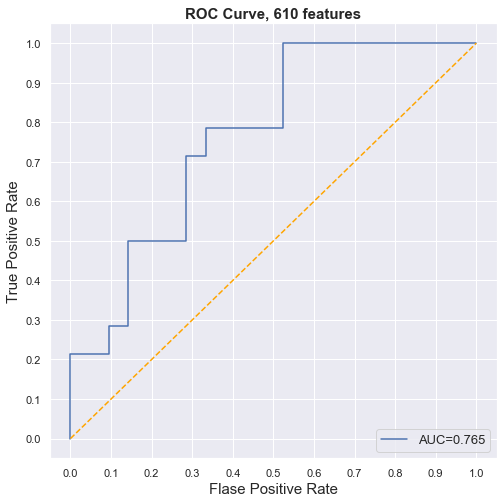

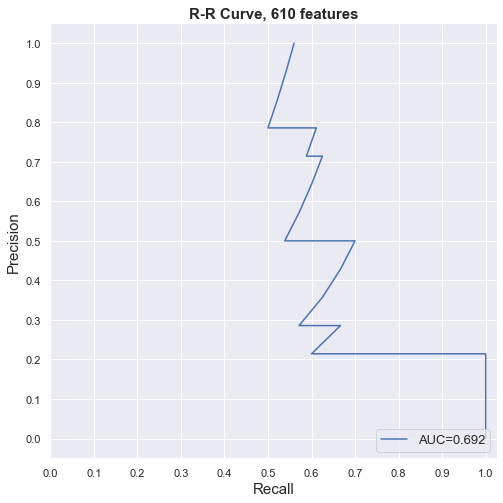

In [53]:
print(pipe_man)
test_score = pipe_man.score(X_test, y_test)
y_pred = pipe_man.predict(X_test)
y_score = [score[1] for score in pipe_man.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {X_test.shape[1]} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {X_test.shape[1]} features")